In [1]:
import mne

import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt

from scipy.signal import csd
import seaborn as sns
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="scipy.signal")


from data_preprocessing import preprocess

In [2]:
#Data Frame from Original Data
df1 = preprocess()

In [3]:
df1

,id,schizo,region,eeg_data,freqs,power,freqs_theta,power_theta,freqs_alpha,power_alpha,freqs_beta,power_beta
0,S164W1,0,F7,"[9.48, 109.94, 308.96, 348.76, 269.15, 208.5, ...","[0.0, 0.016666666666666666, 0.0333333333333333...","[158498.64, 22861.23246172353, 50204.591134708...","[4.0, 4.016666666666667, 4.033333333333333, 4....","[12653.158544343263, 48354.997824733204, 69015...","[8.0, 8.016666666666666, 8.033333333333333, 8....","[26122.060497561743, 20216.5499335299, 26479.2...","[12.0, 12.016666666666666, 12.033333333333333,...","[67789.7194050899, 53651.184341372245, 14663.9..."
1,S164W1,0,F3,"[-151.64, 9.48, 259.68, 318.44, 348.76, 299.48...","[0.0, 0.016666666666666666, 0.0333333333333333...","[136455.69, 8409.359229225813, 38949.763344850...","[4.0, 4.016666666666667, 4.033333333333333, 4....","[17616.150835440894, 92822.94521800874, 35753....","[8.0, 8.016666666666666, 8.033333333333333, 8....","[65223.81328197708, 17790.704272697334, 33462....","[12.0, 12.016666666666666, 12.033333333333333,...","[85636.12307327495, 62779.98957620811, 20635.8..."
2,S164W1,0,F4,"[159.22, 339.29, 519.36, 458.7, 189.55, 58.76,...","[0.0, 0.016666666666666666, 0.0333333333333333...","[52183.59, 26054.72511793837, 48306.3943627817...","[4.0, 4.016666666666667, 4.033333333333333, 4....","[27350.130377207373, 103035.31741294809, 23361...","[8.0, 8.016666666666666, 8.033333333333333, 8....","[40306.14337473731, 8689.729016518411, 5398.53...","[12.0, 12.016666666666666, 12.033333333333333,...","[41202.881615130245, 37928.20118507875, 27839...."
3,S164W1,0,F8,"[259.68, 318.44, 358.24, 259.68, 9.48, -130.79...","[0.0, 0.016666666666666666, 0.0333333333333333...","[81490.68000000001, 11867.360341841628, 57344....","[4.0, 4.016666666666667, 4.033333333333333, 4....","[28052.33049531209, 98464.64021492765, 31475.6...","[8.0, 8.016666666666666, 8.033333333333333, 8....","[56663.7473308475, 21478.899975593606, 21846.7...","[12.0, 12.016666666666666, 12.033333333333333,...","[34437.71856971881, 42838.963068459416, 21701...."
4,S164W1,0,T3,"[238.83, 399.94, 519.36, 458.7, 149.74, -11.37...","[0.0, 0.016666666666666666, 0.0333333333333333...","[109031.83, 33239.29978913151, 20402.886718539...","[4.0, 4.016666666666667, 4.033333333333333, 4....","[27230.940695474685, 51325.96154059415, 16416....","[8.0, 8.016666666666666, 8.033333333333333, 8....","[38862.85559282637, 32335.96769898448, 19762.8...","[12.0, 12.016666666666666, 12.033333333333333,...","[70277.7158139276, 92763.56711893788, 44459.47..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1339,32w1,1,Pz,"[-40.9, 48.76, 209.21, 158.88, -20.45, -171.46...","[0.0, 0.016666666666666666, 0.0333333333333333...","[42580.31999999999, 40506.371012857475, 43940....","[4.0, 4.016666666666667, 4.033333333333333, 4....","[34075.18981837448, 70944.37290985597, 26477.7...","[8.0, 8.016666666666666, 8.033333333333333, 8....","[65239.84069572714, 53987.6222178226, 100021.2...","[12.0, 12.016666666666666, 12.033333333333333,...","[15972.457940048344, 3323.8153445139715, 10079..."
1340,32w1,1,P4,"[48.76, 169.89, 199.78, 108.54, -61.35, -121.1...","[0.0, 0.016666666666666666, 0.0333333333333333...","[34866.18, 40066.88656466791, 51873.5441644073...","[4.0, 4.016666666666667, 4.033333333333333, 4....","[46741.947048847105, 97860.25136131978, 16064....","[8.0, 8.016666666666666, 8.033333333333333, 8....","[67977.03931829463, 64723.56041221257, 85498.0...","[12.0, 12.016666666666666, 12.033333333333333,...","[5244.455209045493, 17408.245710643827, 18500...."
1341,32w1,1,T6,"[188.76, 248.54, 239.1, 169.89, 48.76, 9.44, 9...","[0.0, 0.016666666666666666, 0.0333333333333333...","[26777.709999999995, 35572.958972712506, 44002...","[4.0, 4.016666666666667, 4.033333333333333, 4....","[43216.979730058716, 61507.74634314921, 49234....","[8.0, 8.016666666666666, 8.033333333333333, 8....","[53962.70201381972, 48058.373818026, 69591.832...","[12.0, 12.016666666666666, 12.033333333333333,...","[17390.29803110395, 21032.11576

In [ ]:
def fit_ar_model(eeg_data, lags=10):
    """Fits an AR model and returns AR coefficients and residuals."""
    eeg_data = pd.Series(eeg_data)
    model = AutoReg(eeg_data, lags=lags).fit()
    ar_coefficients = model.params
    residuals = model.resid
    return ar_coefficients, residuals

def compute_shared_ar_model(df, lags=10):
    """Computes a shared AR model by averaging coefficients across healthy and schizophrenic groups."""
    healthy_coeffs = []
    schizo_coeffs = []

    # Separate AR coefficients by group
    for index, row in df.iterrows():
        ar_coefficients, _ = fit_ar_model(row['eeg_data'], lags=lags)
        if row['schizo'] == 0:  # Healthy
            healthy_coeffs.append(ar_coefficients)
        else:  # Schizophrenic
            schizo_coeffs.append(ar_coefficients)

    # Average AR coefficients across groups
    healthy_mean_coeffs = np.mean(healthy_coeffs, axis=0)
    schizo_mean_coeffs = np.mean(schizo_coeffs, axis=0)

    # Compute shared AR coefficients (null hypothesis: no difference)
    shared_coeffs = (healthy_mean_coeffs + schizo_mean_coeffs) / 2
    return shared_coeffs

def simulate_shared_ar_time_series(shared_coeffs, n_points, noise_std=1.0):
    """Simulates time-series data using the shared AR model."""
    lags = len(shared_coeffs) - 1
    simulated = np.zeros(n_points)

    if df1 is not None:  # Ensure `df1` is provided
        # Combine and extract the first `lags` values for all patients
        combined_initial_values = np.vstack([
            np.array(x[:lags]) for x in df1[df1['schizo'] == 0]['eeg_data']
        ] + [
            np.array(x[:lags]) for x in df1[df1['schizo'] == 1]['eeg_data']
        ])

        # Randomized initialization for regions/patients
        simulated[:lags] = np.mean(combined_initial_values, axis=0) + np.random.normal(scale=0.1, size=lags)
    else:
        # Default to random noise if no data is provided
        simulated[:lags] = np.random.normal(scale=noise_std, size=lags)


    for t in range(lags, n_points):
        lagged_values = simulated[t-lags:t][::-1]  # Get the last `lags` values
        ar_contribution = np.dot(shared_coeffs[1:], lagged_values)  # AR component
        noise = np.random.normal(scale=noise_std)  # Independent noise
        simulated[t] = shared_coeffs[0] + ar_contribution + noise  # Intercept + AR + noise

    # Add region-specific variability to the entire time series
    region_noise = np.random.normal(scale=0.05, size=n_points)
    simulated += region_noise
    return simulated

def create_shared_ar_dataframe(df, shared_coeffs, n_points=1000, lags=10):
    """Creates a DataFrame with simulated EEG data using the shared AR model."""
    simulated_data = []

    for index, row in df.iterrows():
        simulated_time_series = simulate_shared_ar_time_series(shared_coeffs, n_points)

        # Compute FFT
        fft_result = np.fft.fft(simulated_time_series)
        fft_magnitude = np.abs(fft_result)
        freqs = np.fft.fftfreq(len(simulated_time_series), 1/128)

        # Extract power for frequency bands
        theta_indices = slice(240, 481)  # 4-8 Hz
        alpha_indices = slice(480, 721)  # 8-13 Hz
        beta_indices = slice(720, 1801)  # 13-30 Hz

        simulated_data.append({
            "id": row['id'],
            "region": row['region'],
            "schizo": row['schizo'],
            "simulated_eeg": simulated_time_series,
            "freqs": freqs.tolist(),
            "power": fft_magnitude.tolist(), 
            "power_theta": fft_magnitude[theta_indices].tolist(),
            "power_alpha": fft_magnitude[alpha_indices].tolist(),
            "power_beta": fft_magnitude[beta_indices].tolist(),
        })

    return pd.DataFrame(simulated_data)

In [ ]:
# Generate shared AR model coefficients
shared_coeffs = compute_shared_ar_model(df1, lags=10)

# Create a simulated DataFrame using the shared AR model
simulated_df = create_shared_ar_dataframe(df1, shared_coeffs, n_points=1000)

In [67]:
def cross_spectral_matrix(patient_id, wave_option='power_beta', surrogate=False):
    
    if surrogate:
        patient_data = simulated_df[simulated_df['id'] == patient_id]
    else:
        patient_data = df1[df1['id'] == patient_id]

    # Create an empty list to hold the power data for each region (channel)
    power_data = []

    sampling_freq = 128

    # Loop through the regions (channels) and extract power data
    for region in patient_data['region'].unique():
        # Filter power data for the current region
        region_data = patient_data[patient_data['region'] == region]
        
        # Append the power data (list) for this region to the list
        power_data.append(region_data[wave_option].values[0])  # Assuming 'power' is a list

    # Convert the list of power data (regions x time points) into a DataFrame
    power_df = pd.DataFrame(power_data).transpose()  # 16 channels x 240 time points

    # Check for NaN values and fill or drop them
    if power_df.isnull().values.any():
        print(f"Warning: Missing values detected in power data for patient {patient_id}")
        power_df = power_df.fillna(0)  # Fill NaN with 0 (you can change this to another method)

    channels = power_df.columns
    csd_matrix = np.zeros((len(channels), len(channels)), dtype=complex)

    #Compute CSD Matrix
    for i, ch1 in enumerate(channels):
        for j, ch2 in enumerate(channels):
            # Compute CSD between two channels
            freqs, csd_values = csd(power_df[ch1], power_df[ch2], fs=sampling_freq, nperseg=256)
            
            # Take the average value of the CSD (optional: could store full spectrum instead)
            csd_matrix[i, j] = np.mean(csd_values)

    #Normalize CSD Matrix
    for i in range(len(channels)):
        for j in range(len(channels)):
            if i != j:
                csd_matrix[i, j] = csd_matrix[i, j] / np.sqrt(csd_matrix[i, i] * csd_matrix[j, j])
    
    np.fill_diagonal(csd_matrix, 1) #I explicitly set the diagonals to 1, because when computing the average across patients, i take the magnitude of the average csd matrix and it messes it up
    # Return the CSD matrix
    return csd_matrix, freqs

In [68]:
def average_csd(patient_ids, wave_option='power_beta', surrogate=False):
    csd_sums = None
    count = 0

    for patient_id in patient_ids:
        csd_matrix, _ = cross_spectral_matrix(patient_id, wave_option, surrogate=surrogate)
        if csd_sums is None:
            csd_sums = csd_matrix
        else:
            csd_sums += csd_matrix
        count += 1

    average_csd_matrix = np.abs(csd_sums / count)
    region_labels = ["F7", "F3", "F4", "F8", "T3", "C3", "Cz", "C4", "T4", "T5", "P3", "Pz", "P4", "T6", "O1", "O2"]
    average_csd_df = pd.DataFrame(average_csd_matrix, columns=region_labels, index=region_labels)

    return average_csd_df

In [95]:
def plot_correlation_matrices(healthy_patients, schizo_patients, wave_option='power_beta', surrogate=False, ax=None):
    # Calculate average correlation matrices for both healthy and schizophrenic patients
    avg_corr_healthy = average_csd(healthy_patients, wave_option=wave_option, surrogate=surrogate)
    avg_corr_schizo = average_csd(schizo_patients, wave_option=wave_option, surrogate=surrogate)
    
    # Compute the global vmin and vmax for consistent color scaling
    global_vmin = min(avg_corr_healthy.min().min(), avg_corr_schizo.min().min())
    global_vmax = max(avg_corr_healthy.max().max(), avg_corr_schizo.max().max())

    corr_difference = avg_corr_healthy - avg_corr_schizo
    
    diff_vmin = 0.06 
    diff_vmax = 0.175

    # diff_vmin = corr_difference.min().min()
    # diff_vmax = corr_difference.max().max()

    # Plot on provided axes
    sns.heatmap(avg_corr_healthy, annot=False, cmap='Oranges', fmt='.2f', xticklabels=True, yticklabels=True,vmin=global_vmin, vmax=global_vmax, ax=ax[0])
    ax[0].set_title(f"Healthy Patients ({wave_option.capitalize()})")
    sns.heatmap(avg_corr_schizo, annot=False, cmap='Oranges', fmt='.2f', xticklabels=True, yticklabels=True,vmin=global_vmin, vmax=global_vmax, ax=ax[1])
    ax[1].set_title(f"Schizophrenic Patients ({wave_option.capitalize()})")
    sns.heatmap(corr_difference, annot=False, cmap='Oranges', fmt='.2f', xticklabels=True, yticklabels=True,vmin=diff_vmin, vmax=diff_vmax, ax=ax[2])
    ax[2].set_title("Difference (Healthy - Schizophrenic)")

    for axis in ax:
        axis.set_xlabel('Regions (Channels)')
        axis.set_ylabel('Regions (Channels)')

    return corr_difference

In [96]:
# Extract patient IDs for healthy and schizophrenic groups
healthy_patients = df1[df1['schizo'] == 0]['id'].unique().tolist()
schizo_patients = df1[df1['schizo'] == 1]['id'].unique().tolist()

In [97]:
simulated_df

,id,region,schizo,simulated_eeg,freqs,power,power_theta,power_alpha,power_beta
0,S164W1,F7,0,"[24.025470723383794, 24.930539913138233, 35.77...","[0.0, 0.128, 0.256, 0.384, 0.512, 0.64, 0.768,...","[4641.489310762883, 854.2730376373427, 412.492...","[32.18865485149825, 33.08989520092953, 23.5826...","[19.947747842761316, 20.42290519403385, 17.290...","[6.764081419014567, 18.643789988589685, 33.825..."
1,S164W1,F3,0,"[24.109053393380957, 24.784098424312237, 35.82...","[0.0, 0.128, 0.256, 0.384, 0.512, 0.64, 0.768,...","[5304.802689241274, 288.7398060521349, 703.177...","[37.59737572702703, 49.52199988564828, 40.7160...","[28.197733199007953, 10.812196400025647, 14.04...","[20.217430893233885, 30.050018082311514, 15.78..."
2,S164W1,F4,0,"[24.063710864981175, 25.03367068275727, 35.959...","[0.0, 0.128, 0.256, 0.384, 0.512, 0.64, 0.768,...","[5560.064660480713, 612.393734217731, 374.9187...","[11.169228079832362, 40.02938968996676, 13.691...","[16.69585901288632, 12.277170675755729, 16.971...","[2.6965859403975228, 27.20716750203378, 21.108..."
3,S164W1,F8,0,"[23.794221259872486, 24.910158487370126, 35.99...","[0.0, 0.128, 0.256, 0.384, 0.512, 0.64, 0.768,...","[4918.700138332574, 671.4663562595146, 573.569...","[5.02230088632654, 21.45196078469322, 23.51942...","[7.122509153314852, 9.991409922044282, 13.5327...","[20.875811100097742, 28.673281358068113, 20.91..."
4,S164W1,T3,0,"[23.938981361765673, 24.800206904336996, 35.92...","[0.0, 0.128, 0.256, 0.384, 0.512, 0.64, 0.768,...","[4989.360851582327, 979.9995776080857, 528.752...","[41.41937573282379, 28.065057069627354, 34.661...","[10.110884235898407, 4.506796987416865, 14.796...","[24.281268907764296, 29.71466297960907, 4.1194..."
...,...,...,...,...,...,...,...,...,...
1339,32w1,Pz,1,"[24.036525383838807, 25.065272918589347, 35.90...","[0.0, 0.128, 0.256, 0.384, 0.512, 0.64, 0.768,...","[5032.744674660437, 495.1956295413043, 590.809...","[32.01546550367056, 22.498292160192154, 27.230...","[21.93336609430025, 11.275813331663153, 23.273...","[19.53801884041212, 22.135697624656455, 28.026..."
1340,32w1,P4,1,"[24.04835920568549, 24.986710039312033, 35.819...","[0.0, 0.128, 0.256, 0.384, 0.512, 0.64, 0.768,...","[5584.951028145257, 422.1608254896871, 351.173...","[28.28434928253046, 36.227938026344546, 27.403...","[17.737570720161703, 16.68086691191654, 15.438...","[20.035741142813443, 26.315914027199224, 19.11..."
1341,32w1,T6,1,"[24.03369817563242, 24.881682794595104, 35.877...","[0.0, 0.128, 0.256, 0.384, 0.512, 0.64, 0.768,...","[5690.849748554347, 373.4012835819447, 555.775...","[30.724046979135277, 40.04786714729638, 15.743...","[23.193096094141804, 27.89733250334408, 25.337...","[19.572289903996374, 27.77927430228079, 39.938..."
1342,32w1,O1,1,"[23.89397892778867, 24.7673636671062, 35.71380...","[0.0, 0.128, 0.256, 0.384, 0.512, 0.64, 0.768,...","[4896.449236943137, 501.4050093249829, 352.277...","[22.649414194375225, 33.11546004609623, 24.478...","[14.347660160569884, 24.034010294438612, 11.92...","[34.19098347800537, 30.690556981510074, 12.694..."


In [99]:
# Observed CSD
observed_healthy_csd = average_csd(healthy_patients, wave_option='power_beta', surrogate=False)
observed_schizo_csd = average_csd(schizo_patients, wave_option='power_beta', surrogate=False)

# Simulated CSD (null hypothesis)
simulated_healthy_csd = average_csd(healthy_patients, wave_option='power_beta', surrogate=True)
simulated_schizo_csd = average_csd(schizo_patients, wave_option='power_beta', surrogate=True)

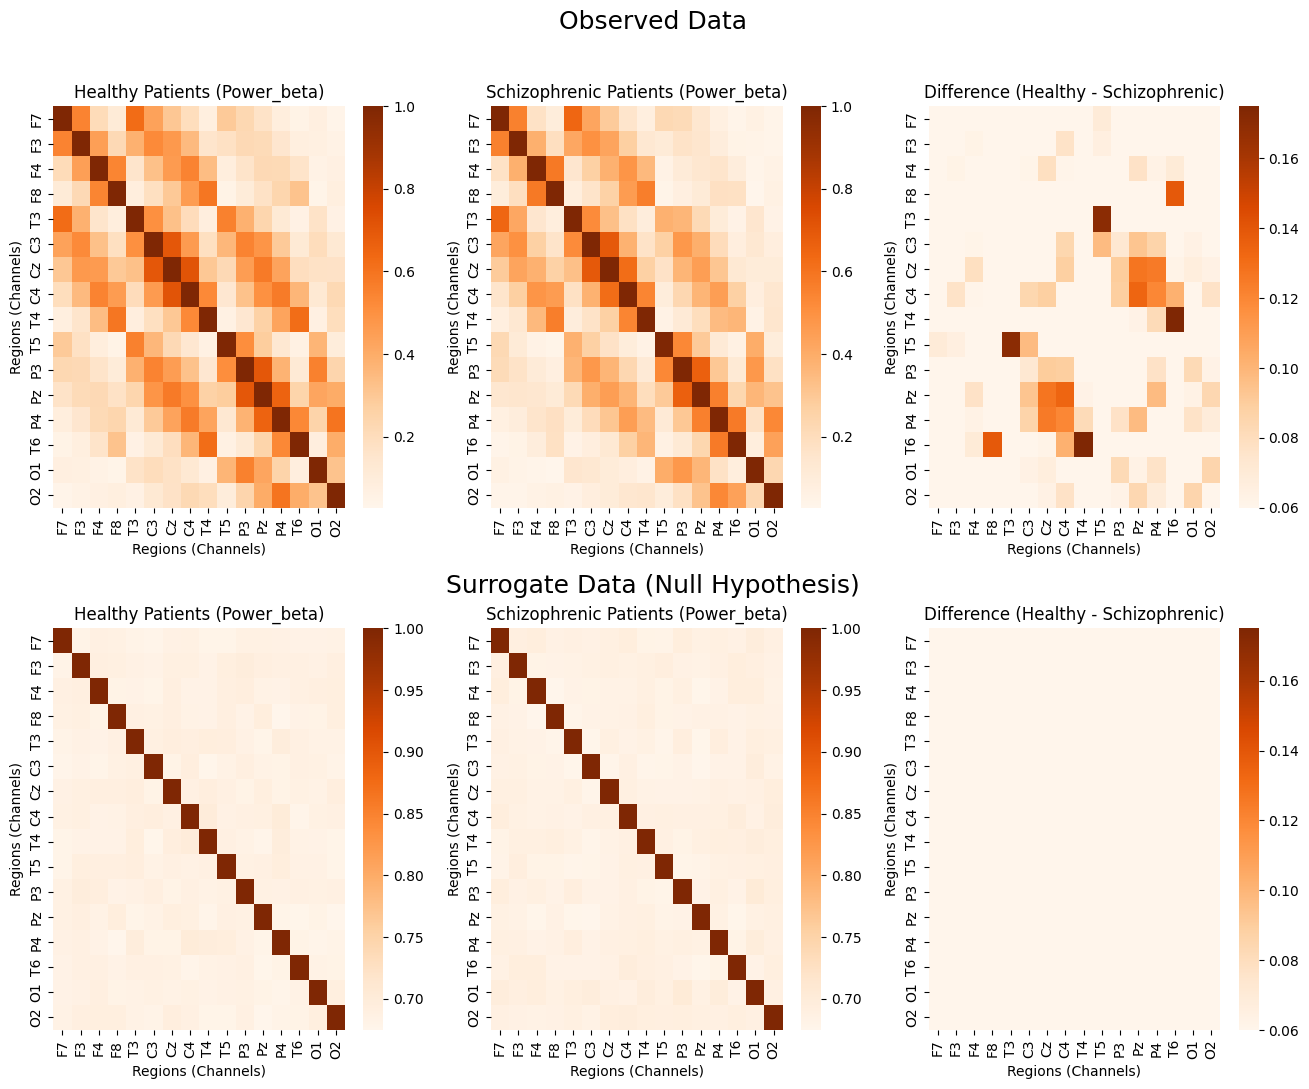

In [147]:
fig, axes = plt.subplots(2, 3, figsize=(16, 12))

observed_diff = plot_correlation_matrices(healthy_patients, schizo_patients, wave_option='power_beta', surrogate=False, ax=axes[0])

surrogate_diff = plot_correlation_matrices(healthy_patients, schizo_patients, wave_option='power_beta', surrogate=True, ax=axes[1])

fig.text(0.5, 0.95, "Observed Data", ha='center', va='center', fontsize=18)
fig.text(0.5, 0.48, "Surrogate Data (Null Hypothesis)", ha='center', va='center', fontsize=18)

# plt.subplots_adjust(hspace=10, wspace=10)
plt.subplots_adjust(hspace=0.3, wspace=0.2)

# plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

In [118]:
observed_diff

,F7,F3,F4,F8,T3,C3,Cz,C4,T4,T5,P3,Pz,P4,T6,O1,O2
F7,0.000000,-0.004836,0.031904,0.014436,-0.018189,0.012532,0.016695,0.041202,-0.001359,0.069644,0.015474,0.024188,0.015658,0.011586,0.012325,0.001580
F3,-0.004836,0.000000,0.062537,0.031050,-0.034504,0.021387,0.041591,0.076478,0.023295,0.065433,0.053363,0.060137,0.050658,0.031908,0.025993,0.017789
F4,0.031904,0.062537,0.000000,-0.038058,0.006705,0.061743,0.078564,0.061317,-0.009318,0.030014,0.054439,0.076888,0.063163,0.070013,0.018359,0.012035
F8,0.014436,0.031050,-0.038058,0.000000,-0.000382,0.021526,0.032835,0.000970,0.027400,0.010095,0.031130,0.059008,0.058461,0.138919,0.014363,0.016173
T3,-0.018189,-0.034504,0.006705,-0.000382,0.000000,-0.016691,-0.006809,0.025520,-0.011959,0.170367,0.018152,0.021502,0.017492,0.008578,0.018809,0.006628
C3,0.012532,0.021387,0.061743,0.021526,-0.016691,0.000000,0.006184,0.084648,0.017318,0.097342,0.072364,0.093247,0.086417,0.035607,0.063877,0.046505
Cz,0.016695,0.041591,0.078564,0.032835,-0.006809,0.006184,0.000000,0.089092,0.035733,0.053017,0.090353,0.127365,0.124871,0.061922,0.066959,0.063719
C4,0.041202,0.076478,0.061317,0.000970,0.025520,0.084648,0.089092,0.000000,-0.014450,0.043731,0.089442,0.133373,0.120157,0.101904,0.047614,0.076748
T4,-0.001359,0.023295,-0.009318,0.027400,-0.011959,0.017318,0.035733,-0.014450,0.000000,0.008862,0.021838,0.062735,0.081743,0.256464,0.009763,0.046442
T5,0.069644,0.065433,0.030014,0.010095,0.170367,0.097342,0.053017,0.043731,0.008862,0.000000,-0.019144,-0.012012,0.016780,0.002544,-0.032481,-0.000023


In [119]:
surrogate_diff

,F7,F3,F4,F8,T3,C3,Cz,C4,T4,T5,P3,Pz,P4,T6,O1,O2
F7,0.000000,-0.010093,-0.005886,0.000930,-0.007170,-0.007308,-0.003959,-0.007380,-0.003729,-0.000586,-0.008415,0.000322,-0.004501,-0.002366,-0.012861,-0.004297
F3,-0.010093,0.000000,0.008531,0.007339,0.001322,-0.004245,-0.000274,0.002653,-0.006173,-0.002001,0.010275,0.006135,0.000435,-0.006221,-0.005430,0.004314
F4,-0.005886,0.008531,0.000000,0.006342,0.000067,-0.002075,0.006453,-0.000980,-0.006078,0.008999,0.002944,0.007751,-0.000069,-0.005706,-0.003780,0.007664
F8,0.000930,0.007339,0.006342,0.000000,0.009876,0.004142,0.007244,-0.001787,-0.008489,0.008638,0.000991,0.009709,-0.010504,0.000588,-0.004255,0.006301
T3,-0.007170,0.001322,0.000067,0.009876,0.000000,0.012727,0.003093,0.007051,0.007000,0.014907,-0.007365,0.001465,0.003315,0.004661,-0.007509,-0.005847
C3,-0.007308,-0.004245,-0.002075,0.004142,0.012727,0.000000,0.003125,0.005025,-0.001272,0.005915,0.007439,0.008063,-0.001341,0.004264,-0.008132,-0.003131
Cz,-0.003959,-0.000274,0.006453,0.007244,0.003093,0.003125,0.000000,-0.002145,0.009344,0.005606,-0.001957,0.007750,-0.006208,0.000957,-0.003491,-0.001284
C4,-0.007380,0.002653,-0.000980,-0.001787,0.007051,0.005025,-0.002145,0.000000,0.010781,-0.004085,0.000166,0.000605,0.010974,-0.017552,0.001135,-0.008191
T4,-0.003729,-0.006173,-0.006078,-0.008489,0.007000,-0.001272,0.009344,0.010781,0.000000,-0.000414,0.002166,-0.011365,0.003789,-0.006482,-0.013129,-0.012654
T5,-0.000586,-0.002001,0.008999,0.008638,0.014907,0.005915,0.005606,-0.004085,-0.000414,0.000000,0.007248,0.008054,0.007913,-0.002644,-0.004556,-0.011408


In [ ]:
#Flatten Surrogate and Observed CSD matrices
flat_observed_diff = observed_diff.values.flatten()
flat_surrogate_diff = surrogate_diff.values.flatten()

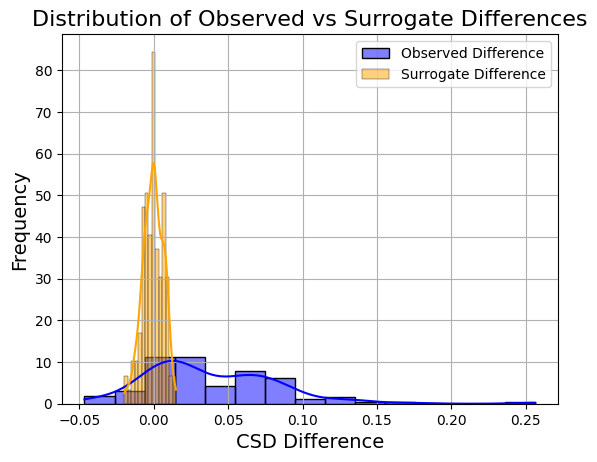

In [150]:
#Visual Verification of Normality
sns.histplot(flat_observed_diff, kde=True, color="blue", label="Observed Difference", stat="density", bins=15)
sns.histplot(flat_surrogate_diff, kde=True, color="orange", label="Surrogate Difference", stat="density", bins=15)

plt.title("Distribution of Observed vs Surrogate Differences", fontsize=16)
plt.xlabel("CSD Difference", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [142]:
from scipy.stats import shapiro

# Normality tests
observed_statistic, observed_pvalue = shapiro(flat_observed_diff)
surrogate_statistic, surrogate_pvalue = shapiro(flat_surrogate_diff)

print("Observed normality p-value:", observed_pvalue)
print("Surrogate normality p-value:", surrogate_pvalue)

Observed normality p-value: 6.284866207797603e-10
Surrogate normality p-value: 0.027155819423486396


In [143]:
observed_statistic

0.9267784753096338

In [145]:
surrogate_statistic

0.9876640597434209

In [122]:
len(flat_observed_diff)
len(flat_surrogate_diff)

256

In [128]:
from scipy.stats import anderson

# Perform Anderson-Darling test for observed data
result_obs = anderson(flat_observed_diff, dist='norm')
print("Observed Anderson-Darling Test:")
print("Statistic:", result_obs.statistic)
print("Critical Values:", result_obs.critical_values)
print("Significance Levels:", result_obs.significance_level)

# Perform Anderson-Darling test for surrogate data
result_surr = anderson(flat_surrogate_diff, dist='norm')
print("\nSurrogate Anderson-Darling Test:")
print("Statistic:", result_surr.statistic)
print("Critical Values:", result_surr.critical_values)
print("Significance Levels:", result_surr.significance_level)

Observed Anderson-Darling Test:
Statistic: 3.5381783343843267
Critical Values: [0.567 0.646 0.775 0.904 1.076]
Significance Levels: [15.  10.   5.   2.5  1. ]

Surrogate Anderson-Darling Test:
Statistic: 0.8342794116980485
Critical Values: [0.567 0.646 0.775 0.904 1.076]
Significance Levels: [15.  10.   5.   2.5  1. ]


In [129]:
from scipy.stats import normaltest

# Perform D'Agostino and Pearson's test for observed data
stat_obs, p_value_obs = normaltest(flat_observed_diff)
print("Observed D'Agostino and Pearson Test:")
print("Statistic:", stat_obs)
print("P-value:", p_value_obs)

# Perform D'Agostino and Pearson's test for surrogate data
stat_surr, p_value_surr = normaltest(flat_surrogate_diff)
print("\nSurrogate D'Agostino and Pearson Test:")
print("Statistic:", stat_surr)
print("P-value:", p_value_surr)

Observed D'Agostino and Pearson Test:
Statistic: 68.45199517913404
P-value: 1.3672190760244654e-15

Surrogate D'Agostino and Pearson Test:
Statistic: 3.257570805609687
P-value: 0.1961676942188162


In [117]:
from scipy.stats import wilcoxon

# Perform Wilcoxon Signed-Rank Test
stat, p_value = wilcoxon(flat_observed_diff, flat_surrogate_diff)

print("Wilcoxon test statistic:", stat)
print("P-value:", p_value)

Wilcoxon test statistic: 2360.0
P-value: 2.6392205004548877e-29


/var/folders/vm/t3wxkm516_b_b9g879dflw400000gn/T/ipykernel_1136/2889541608.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Group", y="Differences", data=data, palette="Set2")


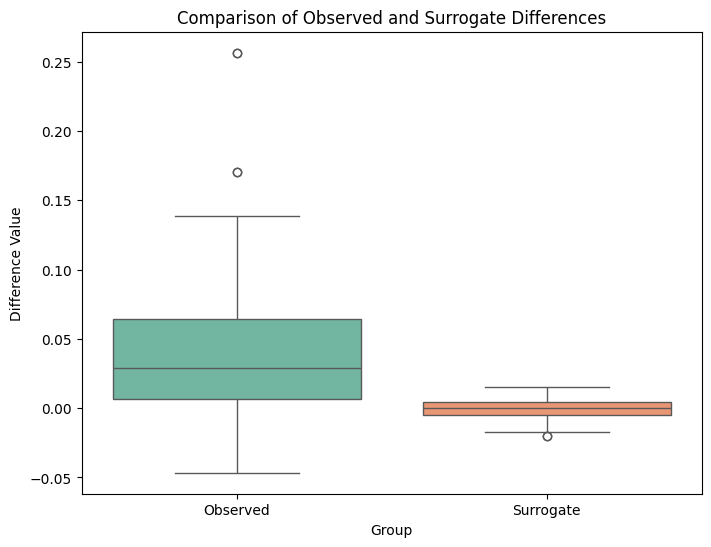

In [116]:
# Combine data for boxplot
import pandas as pd
data = pd.DataFrame({
    "Differences": np.concatenate([flat_observed_diff, flat_surrogate_diff]),
    "Group": ["Observed"] * len(flat_observed_diff) + ["Surrogate"] * len(flat_surrogate_diff)
})

# Plot boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x="Group", y="Differences", data=data, palette="Set2")
plt.title("Comparison of Observed and Surrogate Differences")
plt.ylabel("Difference Value")
plt.show()